## **Problem Statement**

We will solve the above-mentioned problem by applying deep learning algorithms to audio/speech
data. The solution will be to identify emotions in speech.


### **Problem Approach**

#### Importing Base Libraries

In [1]:
import os, glob, pickle, time
import numpy as np
import pandas as pd
from typing import Union

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPClassifier

In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio
import seaborn as sns

In [4]:
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau



#### Load Dataset

Below is our custom built class to process and load audio file information within a dataset and assign a label accordingly.

We've used two datasets in this project,

*  Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess) : 

   The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) contains 7356 files (total size: 24.8 GB). The database contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech includes calm, happy, sad, angry, fearful, surprise, and disgust expressions, and song contains calm, happy, sad, angry, and fearful emotions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

   Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4. These identifiers define the stimulus characteristics:

      Filename identifiers 

      1.  Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
      2.  Vocal channel (01 = speech, 02 = song).
      3.  Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
      4.  Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the ‘neutral’ emotion.
      6.  Statement (01 = “Kids are talking by the door”, 02 = “Dogs are sitting by the door”).
      7.  Repetition (01 = 1st repetition, 02 = 2nd repetition).
      8.  Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

      Filename example: 02-01-06-01-02-01-12.wav 

      1.  Video-only (02)
      2.  Speech (01)
      3.  Fearful (06)
      4.  Normal intensity (01)
      5.  Statement “dogs” (02)
      6.  1st Repetition (01)
      7.  12th Actor (12)
      8.  Female, as the actor ID number is even.

     (Ref : [RAVDESS | SMART Lab](https://smartlaboratory.org/ravdess/))

*  Toronto emotional speech set (Tess)

      These stimuli were modeled on the Northwestern University Auditory Test No. 6 (NU-6; Tillman & Carhart, 1966). A set of 200 target words were spoken in the carrier phrase "Say the word _____' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 stimuli in total. Two actresses were recruited from the Toronto area. Both actresses speak English as their first language, are university educated, and have musical training. Audiometric testing indicated that both actresses have thresholds within the normal range. (2010-06-21)

      (Ref : [Toronto emotional speech set (TESS) - University of Toronto Dataverse](https://dataverse.scholarsportal.info/dataset.xhtml?persistentId=doi:10.5683/SP2/E8H2MF))

In [5]:
class DataLoader:

    available_labels = {
            '01':'neutral',
            '02':'calm',
            '03':'happy',
            '04':'sad',
            '05':'angry',
            '06':'fearful',
            '07':'disgust',
            '08':'surprised'
        }

    to_be_used_labels = ['happy', 'sad', 'angry', 'disgust']

    def __init__(self):
        pass

    def get_available_labels(self) -> dict:
        return self.available_labels

    def get_label_name(self, label_num: str) -> Union[str, None]:
        try:
            return self.available_labels[label_num]
        except KeyError:
            print(f"Label {label_num} is not available.")
            return None

    def get_to_be_used_labels(self) -> list:
        return self.to_be_used_labels

    def set_to_be_used_labels(self, labels: list) -> None:
        self.to_be_used_labels = labels

    def load_data(self, path: str, dataset: str = 'ravdess', load_as: str = 'dataframe') -> Union[pd.DataFrame, list]:
        """Load data from the folder path.

        Args:
            path (str): Path to the folder containing the data. To be passed as glob format (e.g. '*.wav').
            dataset (str): Name of the dataset. Available options: 'ravdess', 'tess'.
            load_as (str, optional): the return type of loaded data. Defaults to 'dataframe'.
        """
        file_list = []
        for file in glob.glob(path):
            if dataset == 'ravdess':
                file_dict = self.process_ravdess(file)
            elif dataset == 'tess':
                file_dict = self.process_tess(file)

            if file_dict['label'] in self.to_be_used_labels:
                file_list.append(file_dict)

        if load_as == 'dataframe':
            return pd.DataFrame(file_list)

        return file_list

    def process_ravdess(self, file: str,) -> dict:
        """Custom function to process ravdess dataset. Returns file base path & label as a dict.

        Args:
            file (str): Base path of individual file.
        """
        file_name=os.path.basename(file)
        return {
            'file_path': file,
            'label': self.get_label_name(file_name.split("-")[2])
        }

    def process_tess(self, file: str,) -> dict:
        """Custom function to process tess dataset. Returns file base path & label as a dict.

        Args:
            file (str): Base path of individual file.
        """
        file_name=os.path.basename(file)
        label = file_name.split(".")[0].split("_")[2]
        if label == 'ps':
            label = 'surprise'

        return {
            'file_path': file,
            'label': label
        }


Out of all emotion labeled data, we're only working with 4 emotion labels i.e.
1.  Happy
2.  Sad
3.  Angry
4.  Disgust

In [6]:
loader = DataLoader()
# Loading filtered audio data from ravdess dataset
ravdess_df = loader.load_data('C:\\Project\\Speech Emotion Recognition\\data\\RAVDESS\\Actor_*\\*.wav')

print('The shape of RAVDESS dataframe is {}'.format(ravdess_df.shape))

The shape of RAVDESS dataframe is (768, 2)


In [7]:
# Loading filtered audio data from tess dataset
tess_df = loader.load_data('C:\\Project\\Speech Emotion Recognition\\data\\TESS\\*AF_*\\*.wav', dataset='tess')

print('The shape of TESS dataframe is {}'.format(tess_df.shape))

The shape of TESS dataframe is (1600, 2)


In [8]:
df = pd.concat([ravdess_df, tess_df]) # merging both dataset to one

df.shape

(2368, 2)

In [9]:
df.head() #top 5 rows

,file_path,label
0,C:\Project\speech-emotion-recognition\data\RAV...,happy
1,C:\Project\speech-emotion-recognition\data\RAV...,happy
2,C:\Project\speech-emotion-recognition\data\RAV...,happy
3,C:\Project\speech-emotion-recognition\data\RAV...,happy
4,C:\Project\speech-emotion-recognition\data\RAV...,happy


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2368 entries, 0 to 1599
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  2368 non-null   object
 1   label      2368 non-null   object
dtypes: object(2)
memory usage: 55.5+ KB


In [11]:
df.isnull().sum()

file_path    0
label        0
dtype: int64

#### EDA of Audio samples

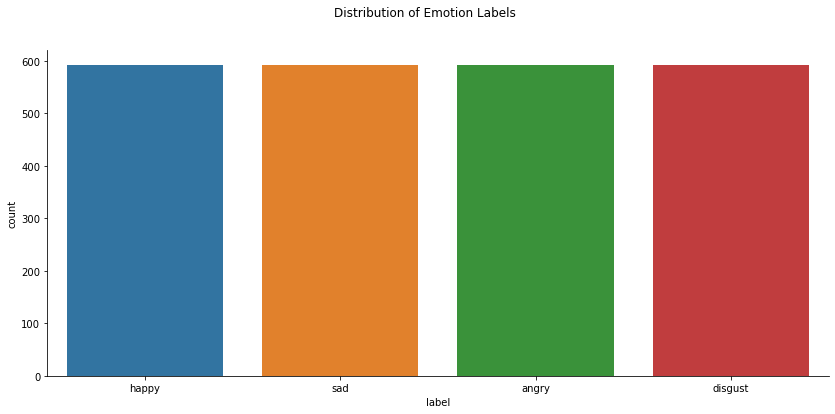

In [12]:
plt.figure(figsize=(14,6))

sns.countplot(data=df, x='label')
plt.suptitle('Distribution of Emotion Labels')
sns.despine()

So, we've 2368 data available divided in equal 4 emotion labels of 592 data within each

In [13]:
labels_list = df['label'].unique().tolist()

labels_list

['happy', 'sad', 'angry', 'disgust']

To visualise a audio better, we can plot waveplots and spectogram for audio signals. 

A waveplot is used to plot waveform of amplitude vs time where the first axis is an amplitude and second axis is time.  

A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time.

In [14]:
def visualise_audio(file_path: str, label: str, play: bool=True):
    """Plot waveplot and spectogram for given audio file

    Args:
        file_path (str): base path of target audio
        label (str): Emotion labels of audio
        play (bool): whether to play audio or not
    """
    file, sample_rate = librosa.load(file_path)

    fig, axes = plt.subplots(ncols=2, figsize=(24, 6))

    librosa.display.waveshow(y=file, sr=sample_rate, ax=axes[0])
    axes[0].set_title('Waveplot for Audio')

    X = librosa.stft(file)
    Xdb = librosa.amplitude_to_db(abs(X))

    librosa.display.specshow(data=Xdb, sr=sample_rate, x_axis='time', y_axis='hz', ax=axes[1])
    axes[1].set_title('Audio Spectogram')

    plt.suptitle(f'Emotion label = {label.capitalize()} & Sample rate = {sample_rate}')
    sns.despine()

    if play:
        return Audio(file, rate=sample_rate)
    
    return None

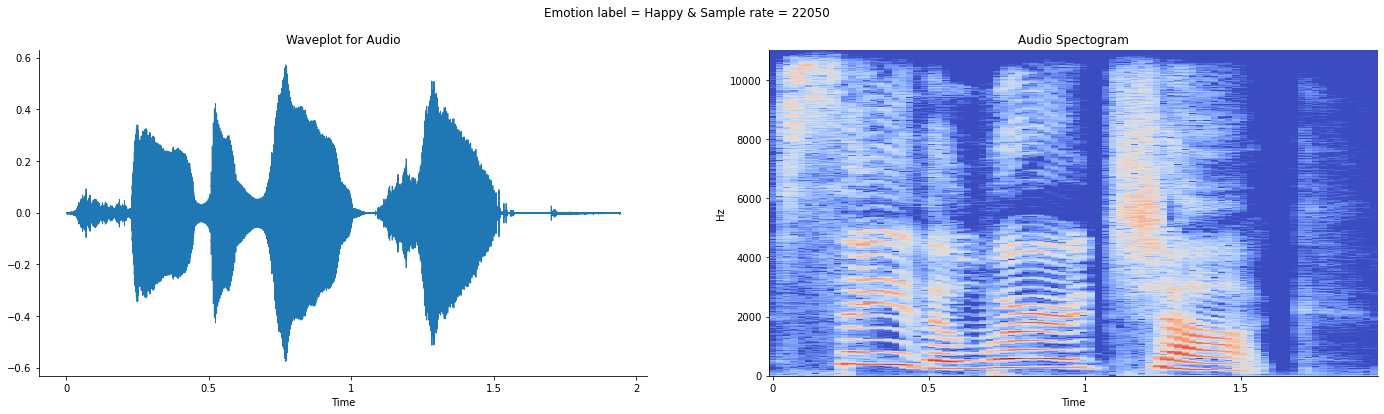

In [15]:
# waveplot and spectogram for a random happy audio
path = df[df['label'] == 'happy'].sample(1)['file_path'].values[0]
visualise_audio(path, label='happy')


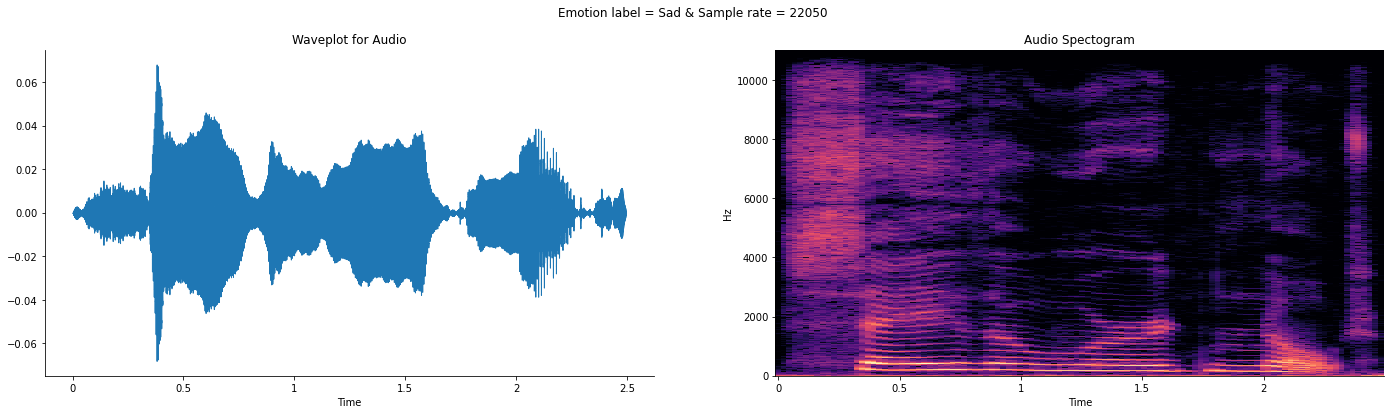

In [16]:
# waveplot and spectogram for a random sad audio
path = df[df['label'] == 'sad'].sample(1)['file_path'].values[0]
visualise_audio(path, label='sad')

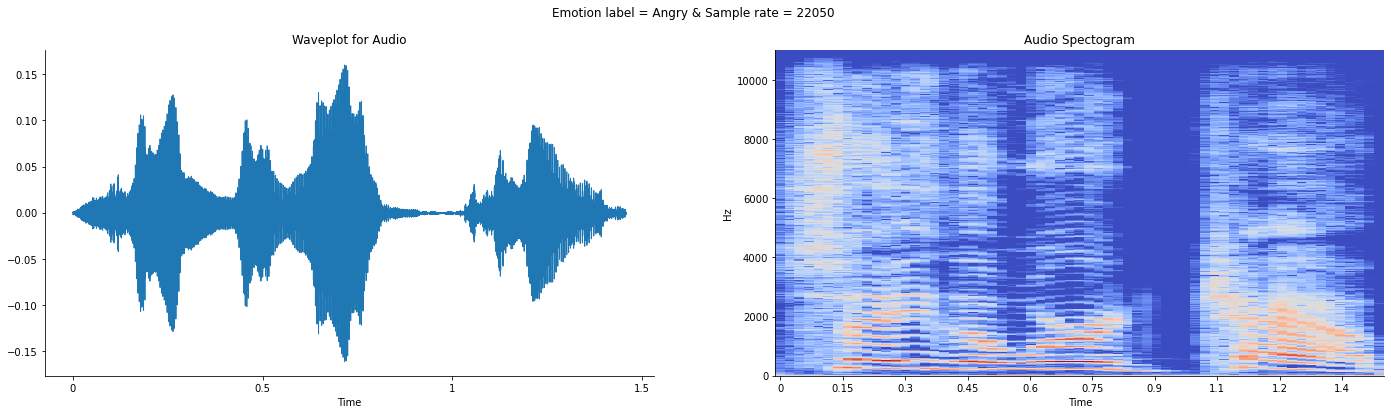

In [17]:
# waveplot and spectogram for a random angry audio
path = df[df['label'] == 'angry'].sample(1)['file_path'].values[0]
visualise_audio(path, label='angry')

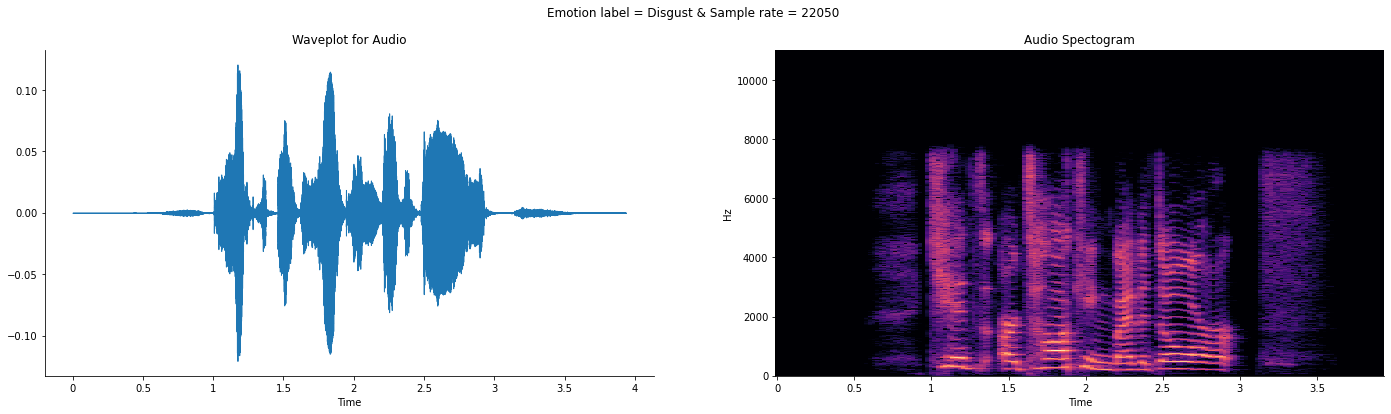

In [18]:
# waveplot and spectogram for a random disgust audio
path = df[df['label'] == 'disgust'].sample(1)['file_path'].values[0]
visualise_audio(path, label='disgust')

#### Data Augmentation

Data Augmentation is a process by which we artificially generate new synthetic data samples. This includes making small changes to data or using deep learning models to generate new data points. 

Data augmentation is useful to improve performance and outcomes of machine learning models by forming new and different examples to train datasets. If the dataset in a machine learning model is rich and sufficient, the model performs better and more accurately.

In [19]:
def noise(data):
    """Add noise to audio data"""
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    """Stretch audio data"""
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    """Shift audio data"""
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    """Pitch audio data"""
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

Original Sample sound label is happy. The sample rate of the file is 22050


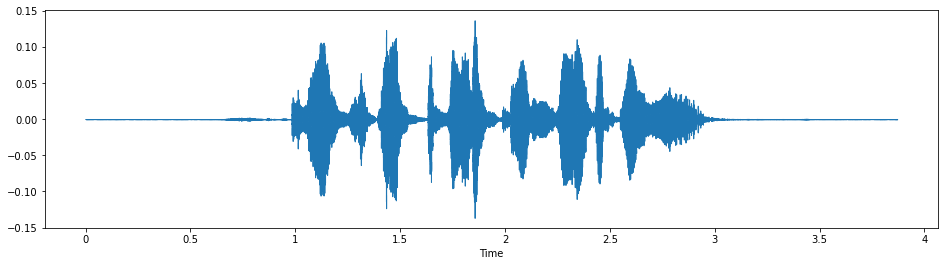

In [20]:
sample_file_arr = df.sample(1)
file, sample_rate = librosa.load(sample_file_arr['file_path'].values[0])

print(f'Original Sample sound label is {sample_file_arr.label.values[0]}. The sample rate of the file is {sample_rate}')

plt.figure(figsize=(16,4))
librosa.display.waveshow(y=file, sr=sample_rate)

Audio(file, rate=sample_rate)

##### Noise Injection

In effect, adding noise expands the size of the training dataset. Each time a training sample is exposed to the model, random noise is added to the input variables making them different every time it is exposed to the model. In this way, adding noise to input samples is a simple form of data augmentation.

After applying Noise Injection on Original Audio...


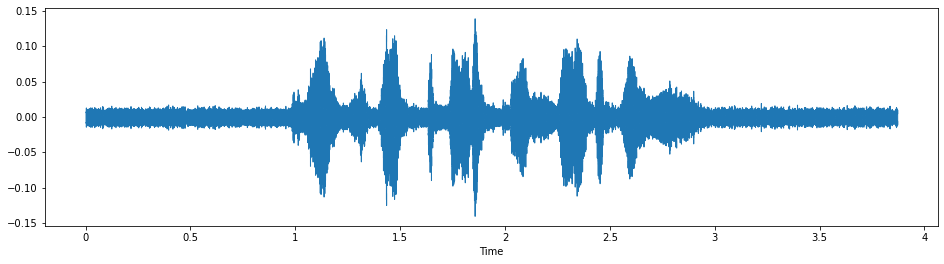

In [21]:
x = noise(file)

print('After applying Noise Injection on Original Audio...')

plt.figure(figsize=(16,4))
librosa.display.waveshow(y=x, sr=sample_rate)

Audio(x, rate=sample_rate)

##### Stretching

Time stretching is the process of changing the speed or duration of an audio signal without affecting its pitch.

After applying Stretching on Original Audio...


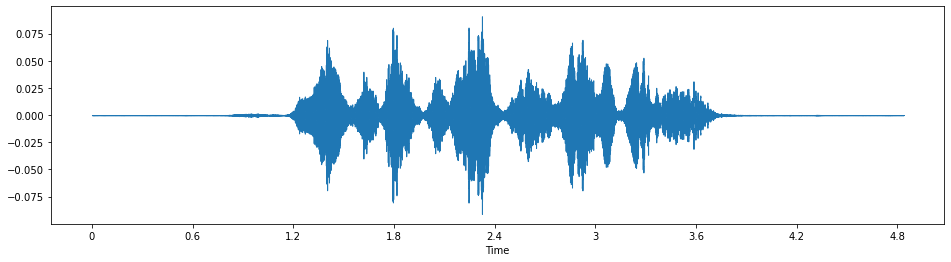

In [22]:
x = stretch(file)

print('After applying Stretching on Original Audio...')

plt.figure(figsize=(16,4))
librosa.display.waveshow(y=x, sr=sample_rate)

Audio(x, rate=sample_rate)

#####  Shifting

It just shift audio to left/right with a random second. If shifting audio to left (fast forward) with x seconds, first x seconds will mark as 0 (i.e. silence). If shifting audio to right (back forward) with x seconds, last x seconds will mark as 0 (i.e. silence).

After applying Shifting on Original Audio...


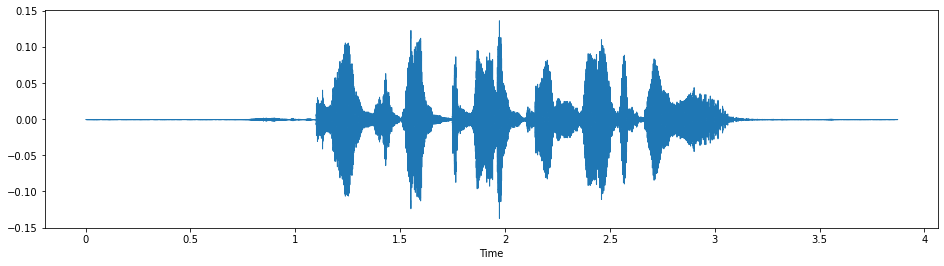

In [23]:
x = shift(file)

print('After applying Shifting on Original Audio...')

plt.figure(figsize=(16,4))
librosa.display.waveshow(y=x, sr=sample_rate)

Audio(x, rate=sample_rate)

##### Pitching

It is also done to add varaince by changing the pitch to a random scale

After applying Pitching on Original Audio...


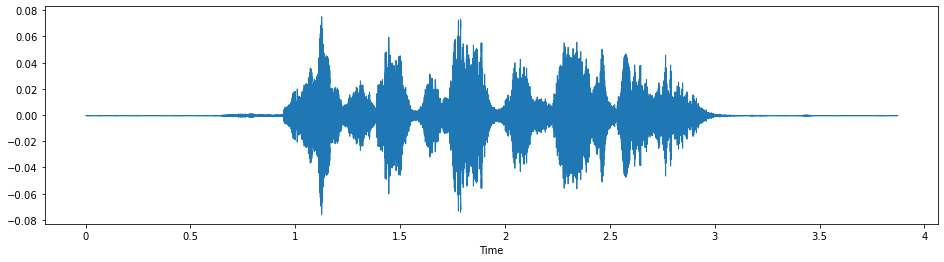

In [24]:
x = pitch(file, sample_rate)

print('After applying Pitching on Original Audio...')

plt.figure(figsize=(16,4))
librosa.display.waveshow(y=x, sr=sample_rate)

Audio(x, rate=sample_rate)

#### Feature Extraction

Features is something that can be quantified using numbers and should be observable in all the data points. Every music file is basically made up of two important things, the sample rate, and the sample data. Now with the help of the sample rate and the sample data, one can perform several transformations on it to extract valuable features out of it.

There are many feature types that can be extracted from a audio file like Zero Cross Rate, Chroma Vector, MFCC, MEL, Spectral features (Spectral Centroid, Spectral Spread, Spectral Flux) etc. 

Out of these, we're extracting and using features liek zcr, chroma, rms, mfcc and mel

In [25]:
def extract_feature(audio: np.ndarray, sample_rate: int, zcr: bool=True, chroma: bool=True,
    rms: bool=True, mfcc: bool=True, mel: bool=True) -> np.ndarray:
    """This function extract features from given audio file and return a numpy array
        with all features stacked in one row

    Args:
        audio (np.ndarray): numpy array representating a audio file
        sample_rate (int): sample rate of audio file
        zcr (bool, optional): extract zero crossing rate. Defaults to True.
        chroma (bool, optional): extract chroma. Defaults to True.
        rms (bool, optional): extract root mean square value. Defaults to True.
        mfcc (bool, optional): extract mfcc. Defaults to True.
        mel (bool, optional): extract mel. Defaults to True.

    Returns:
        np.ndarray: numpy array with all features stacked in one row
    """
    result = np.array([])
    if zcr:
        zcr_arr = np.mean(librosa.feature.zero_crossing_rate(y=audio).T, axis=0)
        result = np.hstack((result, zcr_arr))

    if chroma:
        stft = np.abs(librosa.stft(y=audio))
        chroma_arr = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        result = np.hstack((result, chroma_arr))

    if rms:
        rms_arr = np.mean(librosa.feature.rms(y=audio).T, axis=0)
        result = np.hstack((result, rms_arr))

    if mfcc:
        mfcc_arr = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate).T, axis=0)
        result = np.hstack((result, mfcc_arr))

    if mel:
        mel_arr = np.mean(librosa.feature.melspectrogram(y=audio, sr=sample_rate).T, axis=0)
        result = np.hstack((result, mel_arr))

    return result

In [61]:
def get_feature(path: Union[str, np.ndarray], add_noise: bool=False, add_stretch: bool=False) -> np.ndarray:
    """Add noise or stretch, pitch to the audio file and extract features from it

        Args:
        path (Union[str, np.ndarray]): paths to audio file or numpy array representing a audio file
        add_noise (bool, optional): add noise. Defaults to True.
        add_stretch (bool, optional): add stretching and pitching. Defaults to True.

    Returns:
        np.ndarray: numpy array with all features and augmentated data
    """
    if type(path).__module__ == np.__name__:
        path = path[0]

    file, sample_rate = librosa.load(path, offset=0.6, duration=2.5)

    result = np.array(extract_feature(file, sample_rate=sample_rate))

    if add_noise:
        noise_arr = extract_feature(noise(file), sample_rate=sample_rate)
        result = np.vstack((result, noise_arr))

    if add_stretch:
        stretch_pitch_data = pitch(stretch(file), sampling_rate=sample_rate)
        stretch_pitch_arr =extract_feature(stretch_pitch_data, sample_rate=sample_rate)
        result = np.vstack((result, stretch_pitch_arr))

    return result

In [27]:
def run_feature_extraction(data, feature_col: Union[list, str]) -> np.ndarray:
    """Run feature extraction process on given dataframe

    Args:
        data (_type_): pandas dataframe to extract features from
        feature_col (Union[list, str]): feature column name or list

    Returns:
        np.ndarray: numpy array with all features and augmentated data
    """
    file_path_arr = data[feature_col].to_numpy().reshape(-1, 1)

    # X = np.apply_along_axis(get_feature, axis=1, arr=file_path_arr)
    X = np.array(list(map(get_feature, file_path_arr))) # this one faster

    # creating 2d array ((i, j, k) -> ((i*j), k))
    X = X.reshape((X.shape[0]*X.shape[1]), X.shape[2])

    print(f'The shape of X variable is {X.shape}')
    return X

In [29]:
def run_label_extraction(data, feature_col: Union[list, str], lblencoder, repeat_count: int=3) -> np.ndarray:
    """Extract labels from given dataframe using label encoder, and replicate the labels
        according to augmented data count

    Args:
        data (_type_): pandas dataframe to extract labels from
        feature_col (Union[list, str]): feature column name or list
        lblencoder (_type_): LabelEncoder() object
        repeat_count (int, optional): repeat count. Defaults to 3.

    Returns:
        np.ndarray: numpy array with all labels
    """
    y =  lblencoder.transform(data[feature_col])
    # as we're creating 3 copies, one with original,
    # one with noise & one with streting and pitching
    y = np.repeat(y, 3)

    print(f'The shape of y variable is {y.shape}')
    return y

We're going to split the dataset first then perform data augmentation and feature extraction separately. Because,
if we split training data after augmentation process, then model would have learn part of informations while
training which causes data leakage.

In [36]:
train_df, test_df = train_test_split(df, test_size=0.25, random_state=10)

print(f'The length of train_df & test_df is respectively {train_df.shape[0]} & {test_df.shape[0]}')

The length of train_df & test_df is respectively 1776 & 592


In [31]:
%%time
X_train = run_feature_extraction(train_df, 'file_path')
X_test = run_feature_extraction(test_df, 'file_path')


The shape of X variable is (5328, 162)
The shape of X variable is (1776, 162)
Wall time: 10min 27s


In [32]:
lblencoder = LabelEncoder()
# fit on whole dataset first, then
# within function run transform only
_ = lblencoder.fit(df['label'])

y_train = run_label_extraction(train_df, 'label', lblencoder)
y_test = run_label_extraction(test_df, 'label', lblencoder)

The shape of y variable is (5328,)
The shape of y variable is (1776,)


#### Data Scaling

Normally, machine learning algorithm tends to perform better when data is scaled at a particular range. Normalization scales each input variable separately to the range 0-1, which is the range for floating-point values where we have the most precision. Standardization scales each input variable separately by subtracting the mean (called centering) and dividing by the standard deviation to shift the distribution to have a mean of zero and a standard deviation of one.

In [48]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler  =  StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### sklearn.neural_network.MLPClassifier

MLPClassifier stands for Multi-layer Perceptron classifier which in the name itself connects to a Neural Network. Unlike other classification algorithms such as Support Vectors or Naive Bayes Classifier, MLPClassifier relies on an underlying Neural Network to perform the task of classification.

In [49]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(256,100,100), max_iter=1000)
model.fit(X_train_scaled, y_train)

MLPClassifier(hidden_layer_sizes=(256, 100, 100), max_iter=1000)

In [50]:
y_pred = model.predict(X_test_scaled)

In [51]:
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: {:.2f}%".format(accuracy*100))

print(classification_report(y_test, y_pred))

Accuracy: 89.19%
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       495
           1       0.87      0.85      0.86       459
           2       0.83      0.90      0.86       390
           3       0.92      0.91      0.92       432

    accuracy                           0.89      1776
   macro avg       0.89      0.89      0.89      1776
weighted avg       0.89      0.89      0.89      1776



On using MinMaxScaler we've acquired an accuracy of 86.32%,but with StandardScaler the accuracy's been increased to 89.58%. Using Multi Layer Perceptron with a hidden layer structure of 256 neurons in 1st layer and 100 neurons in each of 2nd and 3rd layers, our model acquired best f1 score of 0.92 on `angry` and `sad` emotion labels

#### 1D Convolutional Layer

In [53]:
onehotencoder = OneHotEncoder()

_ = onehotencoder.fit(np.array(df['label']).reshape(-1, 1))

y_train = onehotencoder.transform(np.array(train_df['label']).reshape(-1, 1)).toarray()
y_test = onehotencoder.transform(np.array(test_df['label']).reshape(-1, 1)).toarray()

y_train = np.repeat(y_train, 3, axis=0)
y_test = np.repeat(y_test, 3, axis=0)

In [34]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [114]:
X_train_3d = np.expand_dims(X_train_scaled, axis=2)
X_test_3d = np.expand_dims(X_test_scaled, axis=2)

In [115]:
X_train.shape, y_train.shape

((5328, 162), (5328, 4))

In [134]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train_scaled.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.3))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=4, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 162, 256)          1536      
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 81, 256)           0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 81, 128)           163968    
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 41, 128)           0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 41, 128)           0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 41, 64)            41024     
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 21, 64)           

In [135]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(X_train_3d, y_train, batch_size=64, epochs=50, validation_data=(X_test_3d, y_test), callbacks=[rlrp])

Epoch 1/50
84/84 [==============================] - 1s 16ms/step - loss: 1.0690 - accuracy: 0.5452 - val_loss: 0.8302 - val_accuracy: 0.6909
Epoch 2/50
84/84 [==============================] - 1s 10ms/step - loss: 0.7748 - accuracy: 0.7057 - val_loss: 0.6634 - val_accuracy: 0.7579
Epoch 3/50
84/84 [==============================] - 1s 10ms/step - loss: 0.6207 - accuracy: 0.7549 - val_loss: 0.5766 - val_accuracy: 0.7708
Epoch 4/50
84/84 [==============================] - 1s 10ms/step - loss: 0.5694 - accuracy: 0.7665 - val_loss: 0.5287 - val_accuracy: 0.7686
Epoch 5/50
84/84 [==============================] - 1s 9ms/step - loss: 0.4930 - accuracy: 0.7952 - val_loss: 0.5040 - val_accuracy: 0.7872
Epoch 6/50
84/84 [==============================] - 1s 10ms/step - loss: 0.5039 - accuracy: 0.7934 - val_loss: 0.4632 - val_accuracy: 0.7990
Epoch 7/50
84/84 [==============================] - 1s 10ms/step - loss: 0.4637 - accuracy: 0.8071 - val_loss: 0.4778 - val_accuracy: 0.8063
Epoch 8/50
84/

56/56 [==============================] - 0s 7ms/step - loss: 0.4392 - accuracy: 0.8750
Accuracy of model on test data :  87.5 %


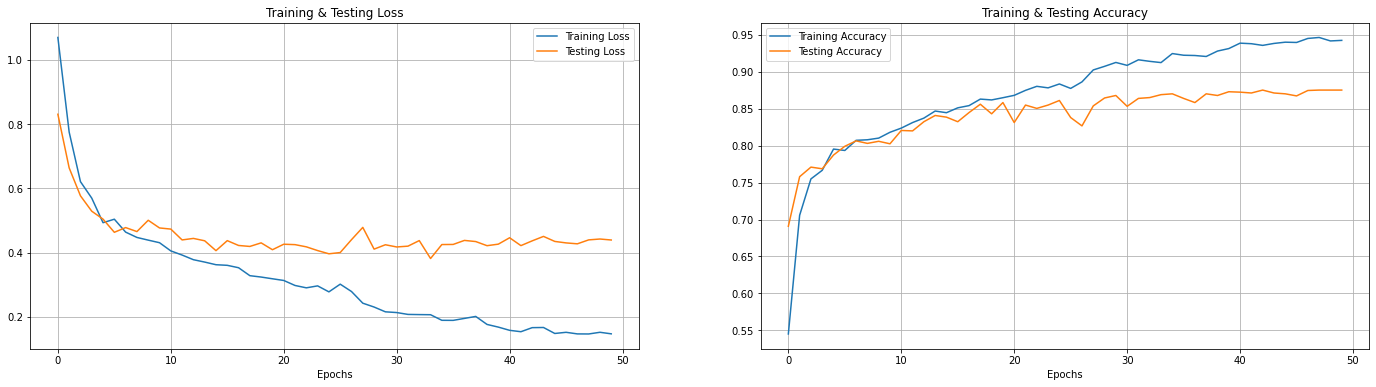

In [163]:
print("Accuracy of model on test data : " , model.evaluate(X_test_3d, y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2, figsize=(24, 6))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].grid()

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].grid()

plt.show()

In [62]:
y_pred = model.predict(X_test_3d)

y_pred_lbl = onehotencoder.inverse_transform(y_pred)
y_test_lbl = onehotencoder.inverse_transform(y_test)

NameError: name 'X_test_3d' is not defined

In [162]:
print(classification_report(y_test_lbl, y_pred_lbl))

              precision    recall  f1-score   support

       angry       0.93      0.88      0.90       495
     disgust       0.88      0.83      0.85       459
       happy       0.80      0.88      0.84       390
         sad       0.89      0.92      0.90       432

    accuracy                           0.88      1776
   macro avg       0.87      0.88      0.87      1776
weighted avg       0.88      0.88      0.88      1776



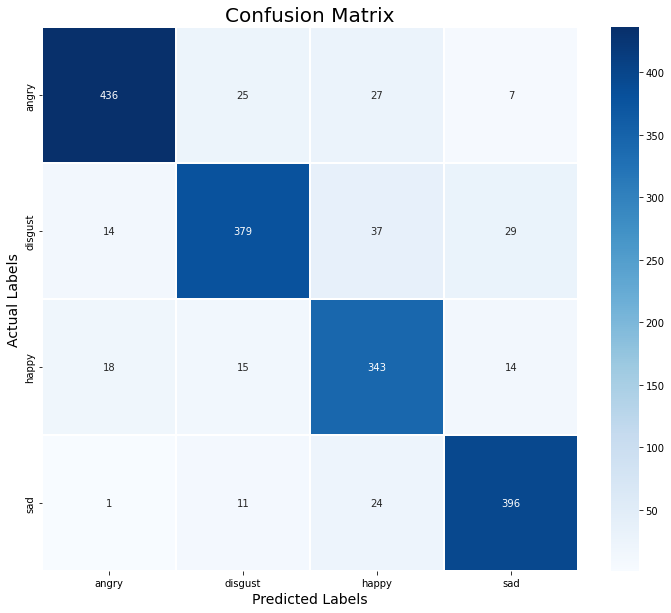

In [160]:
cm = confusion_matrix(y_test_lbl, y_pred_lbl)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in onehotencoder.categories_] , columns = [i for i in onehotencoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

### Reference

*  https://towardsdatascience.com/how-i-understood-what-features-to-consider-while-training-audio-files-eedfb6e9002b
*  https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225
*  https://towardsdatascience.com/understanding-audio-data-fourier-transform-fft-spectrogram-and-speech-recognition-a4072d228520